# Code to create violin plots for HRApop validations 

## Import statements

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import ttest_ind, ttest_ind_from_stats

## Global variables

In [3]:
hra_pop_version = "0.10.1"

## Import data

In [5]:
validation_data = pd.read_csv(filepath_or_buffer=f"../../../hra-pop/output-data/v{hra_pop_version}/reports/atlas/validation-v2p1.csv")

## Transform data 

### Create look-up from AS to organ

In [6]:
organ_look_up = {
    'left ureter': "ureter",
    'cecum': "large intestine",
    'papilla': "kidney",
    'descending colon': "large intestine",
    'rectum': "large intestine",
    'ileum': "small intestine",
    'ascending colon': "large intestine",
    'skin of body': "skin",
    'skin':'skin',
    'outer cortex of kidney': "kidney",
    'left atrium': "heart",
    'right ventricle': "heart",
    'ascending duodenum': "small intestine",
    'jejunum': "small intestine",
    'septum': "heart",
    'renal column (column of bertin)': "kidney",
    'transverse colon': "large intestine",
    'hilum': "spleen",
    'inferior duodenum': "small intestine",
    'left ventricle': "heart",
    'kidney capsule': "kidney",
    'descending duodenum': "small intestine",
    'renal pyramid': "kidney",
    'fundus of urinary bladder': "urinary bladder",
    'right atrium': "heart",
    'terminal ileum': "small intestine",
    'sigmoid colon': "large intestine",
    'renal papilla': "kidney"
}

validation_data['organ_as_label'] = validation_data['as_label'].map(organ_look_up) + \
    " - " + validation_data['as_label']

### Unify skin and skin of body
The `as_label` column in the source data lists `skin` and `skin of body`, so we need to unify those to avoid showing skin twice. This is captured in this [GitHub issue](https://github.com/x-atlas-consortia/hra-pop/issues/77).

In [7]:
validation_data['as_label'] = validation_data['as_label'].replace('skin of body', 'skin')

## Functions for formatting and plotting

In [8]:
# Define a function to format tick labels
def format_ticks(x):
    """
    Takes a number and returns it with one decimal

    Args:
    x (float): a number

    Returns:
    float: the number with one decimal
    """
    return "{:.1f}".format(x)


def plot(tool):
    """
    Creates a violin plot for one tool only

    Args:
    tool (string): a cell type annotation tool
    """
    for_plot = validation_data[
        (validation_data.as_tool == tool) & (validation_data.tool == tool)
    ]
    violin = sns.violinplot(
        data=for_plot,
        x="organ_as_label",
        y="similarity",
        density_norm="width",
        cut=0,
        inner="box",
        hue="as_in_collisions",
        split=True,
        order=sorted(for_plot['organ_as_label'].unique())
    )

    # add strip plot with jitter
    sns.stripplot(
        data=for_plot,
        x="organ_as_label",
        y="similarity",
        jitter=True,
        dodge=True,
        hue="as_in_collisions",
        linewidth=1,
        edgecolor="black",
        order=sorted(for_plot['organ_as_label'].unique())
    )

    set_theme(violin=violin)


def set_theme(violin):
    """
    Takes a plot and adds a theme

    Args:
    violin (sns plot): a violin plot
    """
    violin = violin

    plt.xticks(rotation=90)
    sns.set_theme(rc={"figure.figsize": (40, 15)})

    #  change the axis labels
    violin.set_xlabel("Anatomical Structure", fontsize=30)
    violin.set_ylabel("Weighted Cosine Similarity", fontsize=30)

    # get the Axes object of the current plot
    ax = plt.gca()

    # Change the size of the x-axis tick labels
    ax.tick_params(axis="x", labelsize=25)
    ax.tick_params(axis="y", labelsize=25)
    plt.legend(
        title="Does dataset actually collide with\n anatomical structure?", loc="best"
    )
    plt.setp(ax.get_legend().get_texts(), fontsize="22")  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize="32")  # for legend title


def report_numbers(as_label, tool, as_in_collisions):
    """Prints the number of datasets analyzed for all anatomical structures with one tool and given whether the dataset actually does collide with the AS

    Args:
        as_label (string ): AS label
        tool (string): CTAnn tool
    """
    print(
        f"For {len(validation_data[(validation_data.as_label == as_label) & (validation_data.as_tool == tool) & (validation_data.tool == tool) & (validation_data.as_in_collisions == as_in_collisions)].dataset.unique())} out of {len(validation_data[(validation_data.as_label == as_label) & (validation_data.as_tool == tool) & (validation_data.tool == tool) ])} datasets " +
        f"annotated through {tool} for {as_label}, does the extraction site of the dataset actually does collide with {as_label}? {as_in_collisions}."
    )


def get_unique_as_in_data(tool):
    """Get a list of all AS and organs for which we have tool comparisons

    Args:
        tool (string): a CTAnn tool

    Returns:
        list: a list of strings
    """
    for_plot = validation_data[
        (validation_data.as_tool == tool) & (validation_data.tool == tool)
    ]

    # make new column with combomof as_label and organ
    return list(for_plot.organ_as_label.unique())

## Report numbers

In [9]:
# Total numbers
as_label = "right atrium"
datasets_for_right_atrium = validation_data[validation_data.as_label == as_label]
print(
    f"The total number of datasets in the {as_label} is: {len(datasets_for_right_atrium.dataset.unique())}"
)

# Unique AS per organ
tools = ("azimuth", "celltypist", "popv")
unique_as = set()

for tool in tools:
    for as_label in get_unique_as_in_data(tool):
        unique_as.add(as_label)

print(f"Found {len(unique_as)} unique AS across 3 plots: {unique_as}")

The total number of datasets in the right atrium is: 193
Found 28 unique AS across 3 plots: {'kidney - outer cortex of kidney', 'kidney - renal papilla', 'heart - right atrium', 'large intestine - transverse colon', 'small intestine - jejunum', 'small intestine - descending duodenum', 'small intestine - ascending duodenum', 'small intestine - terminal ileum', 'urinary bladder - fundus of urinary bladder', 'spleen - hilum', 'skin - skin', 'heart - right ventricle', 'large intestine - sigmoid colon', 'ureter - left ureter', 'large intestine - rectum', 'heart - left ventricle', 'kidney - renal column (column of bertin)', 'skin - skin of body', 'small intestine - ileum', 'large intestine - descending colon', 'kidney - kidney capsule', 'kidney - papilla', 'kidney - renal pyramid', 'small intestine - inferior duodenum', 'heart - septum', 'heart - left atrium', 'large intestine - ascending colon', 'large intestine - cecum'}


### Azimuth

For 16 out of 139 datasets annotated through azimuth for right atrium, does the extraction site of the dataset actually does collide with right atrium? True.
For 123 out of 139 datasets annotated through azimuth for right atrium, does the extraction site of the dataset actually does collide with right atrium? False.


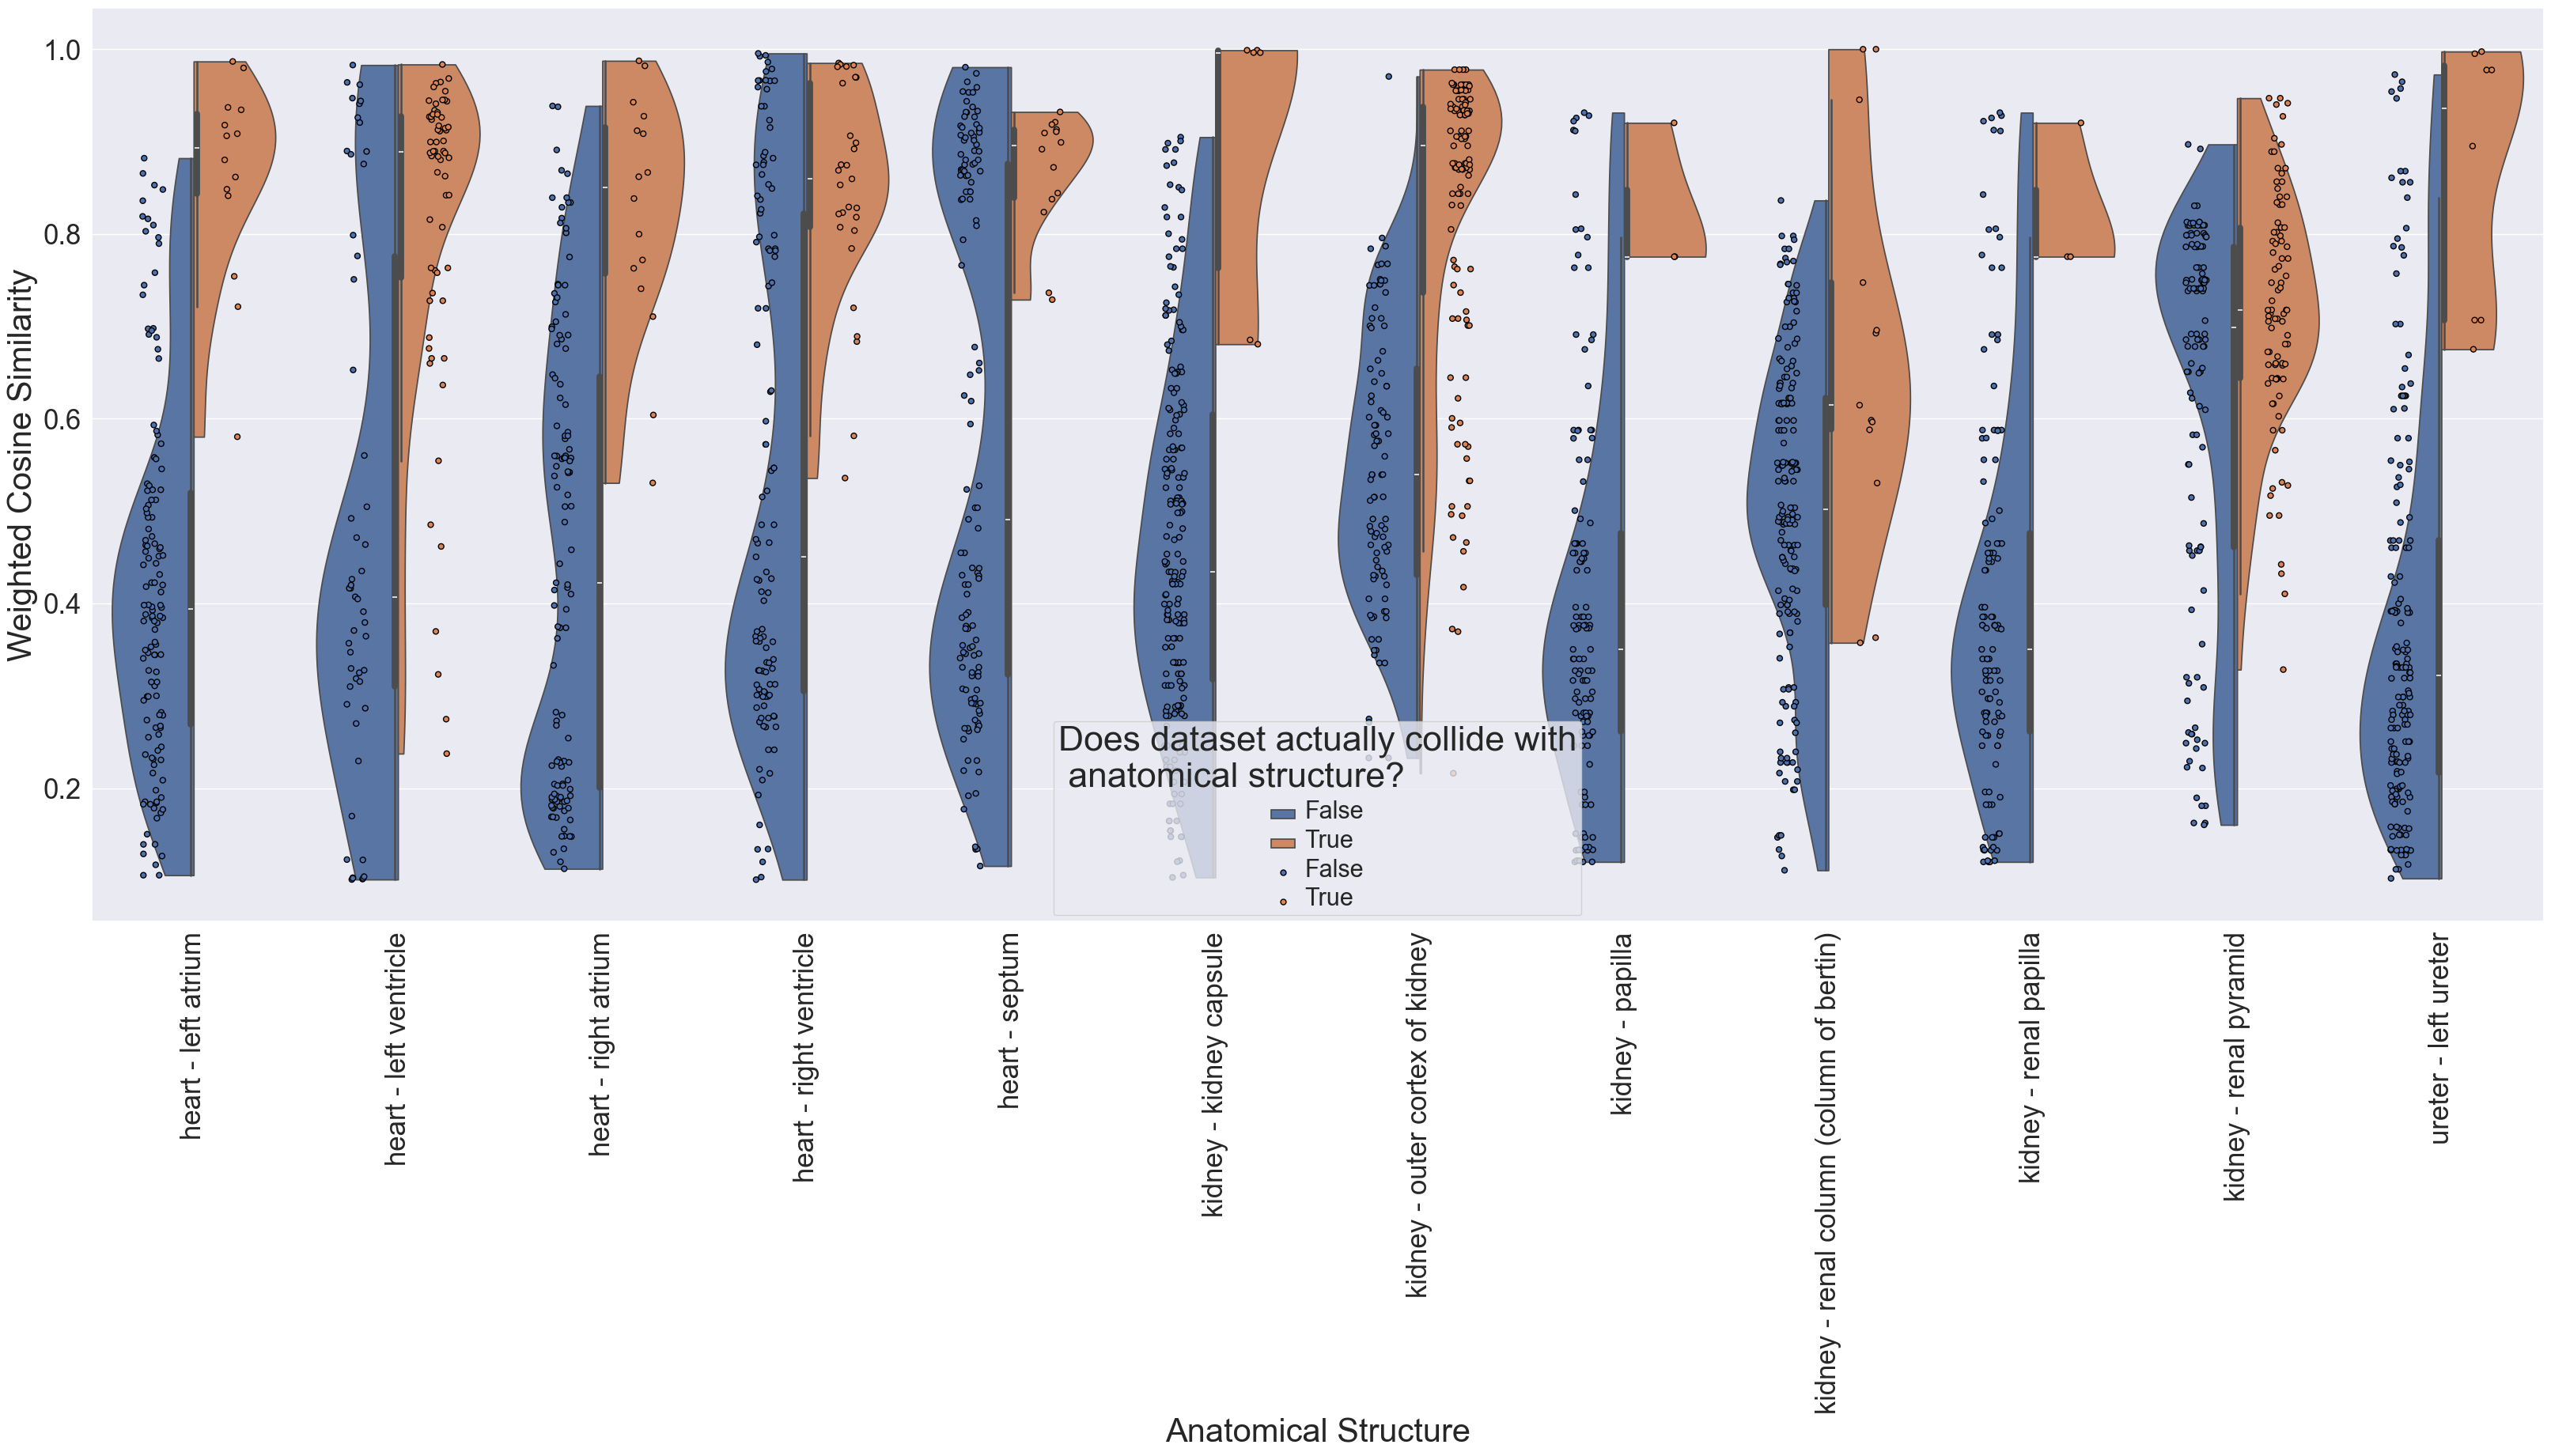

In [11]:
tool = "azimuth"
report_numbers("right atrium", tool, True)
report_numbers("right atrium", tool, False)
plot(tool)

### CellTypist

For 16 out of 117 datasets annotated through celltypist for right atrium, does the extraction site of the dataset actually does collide with right atrium? True.
For 101 out of 117 datasets annotated through celltypist for right atrium, does the extraction site of the dataset actually does collide with right atrium? False.


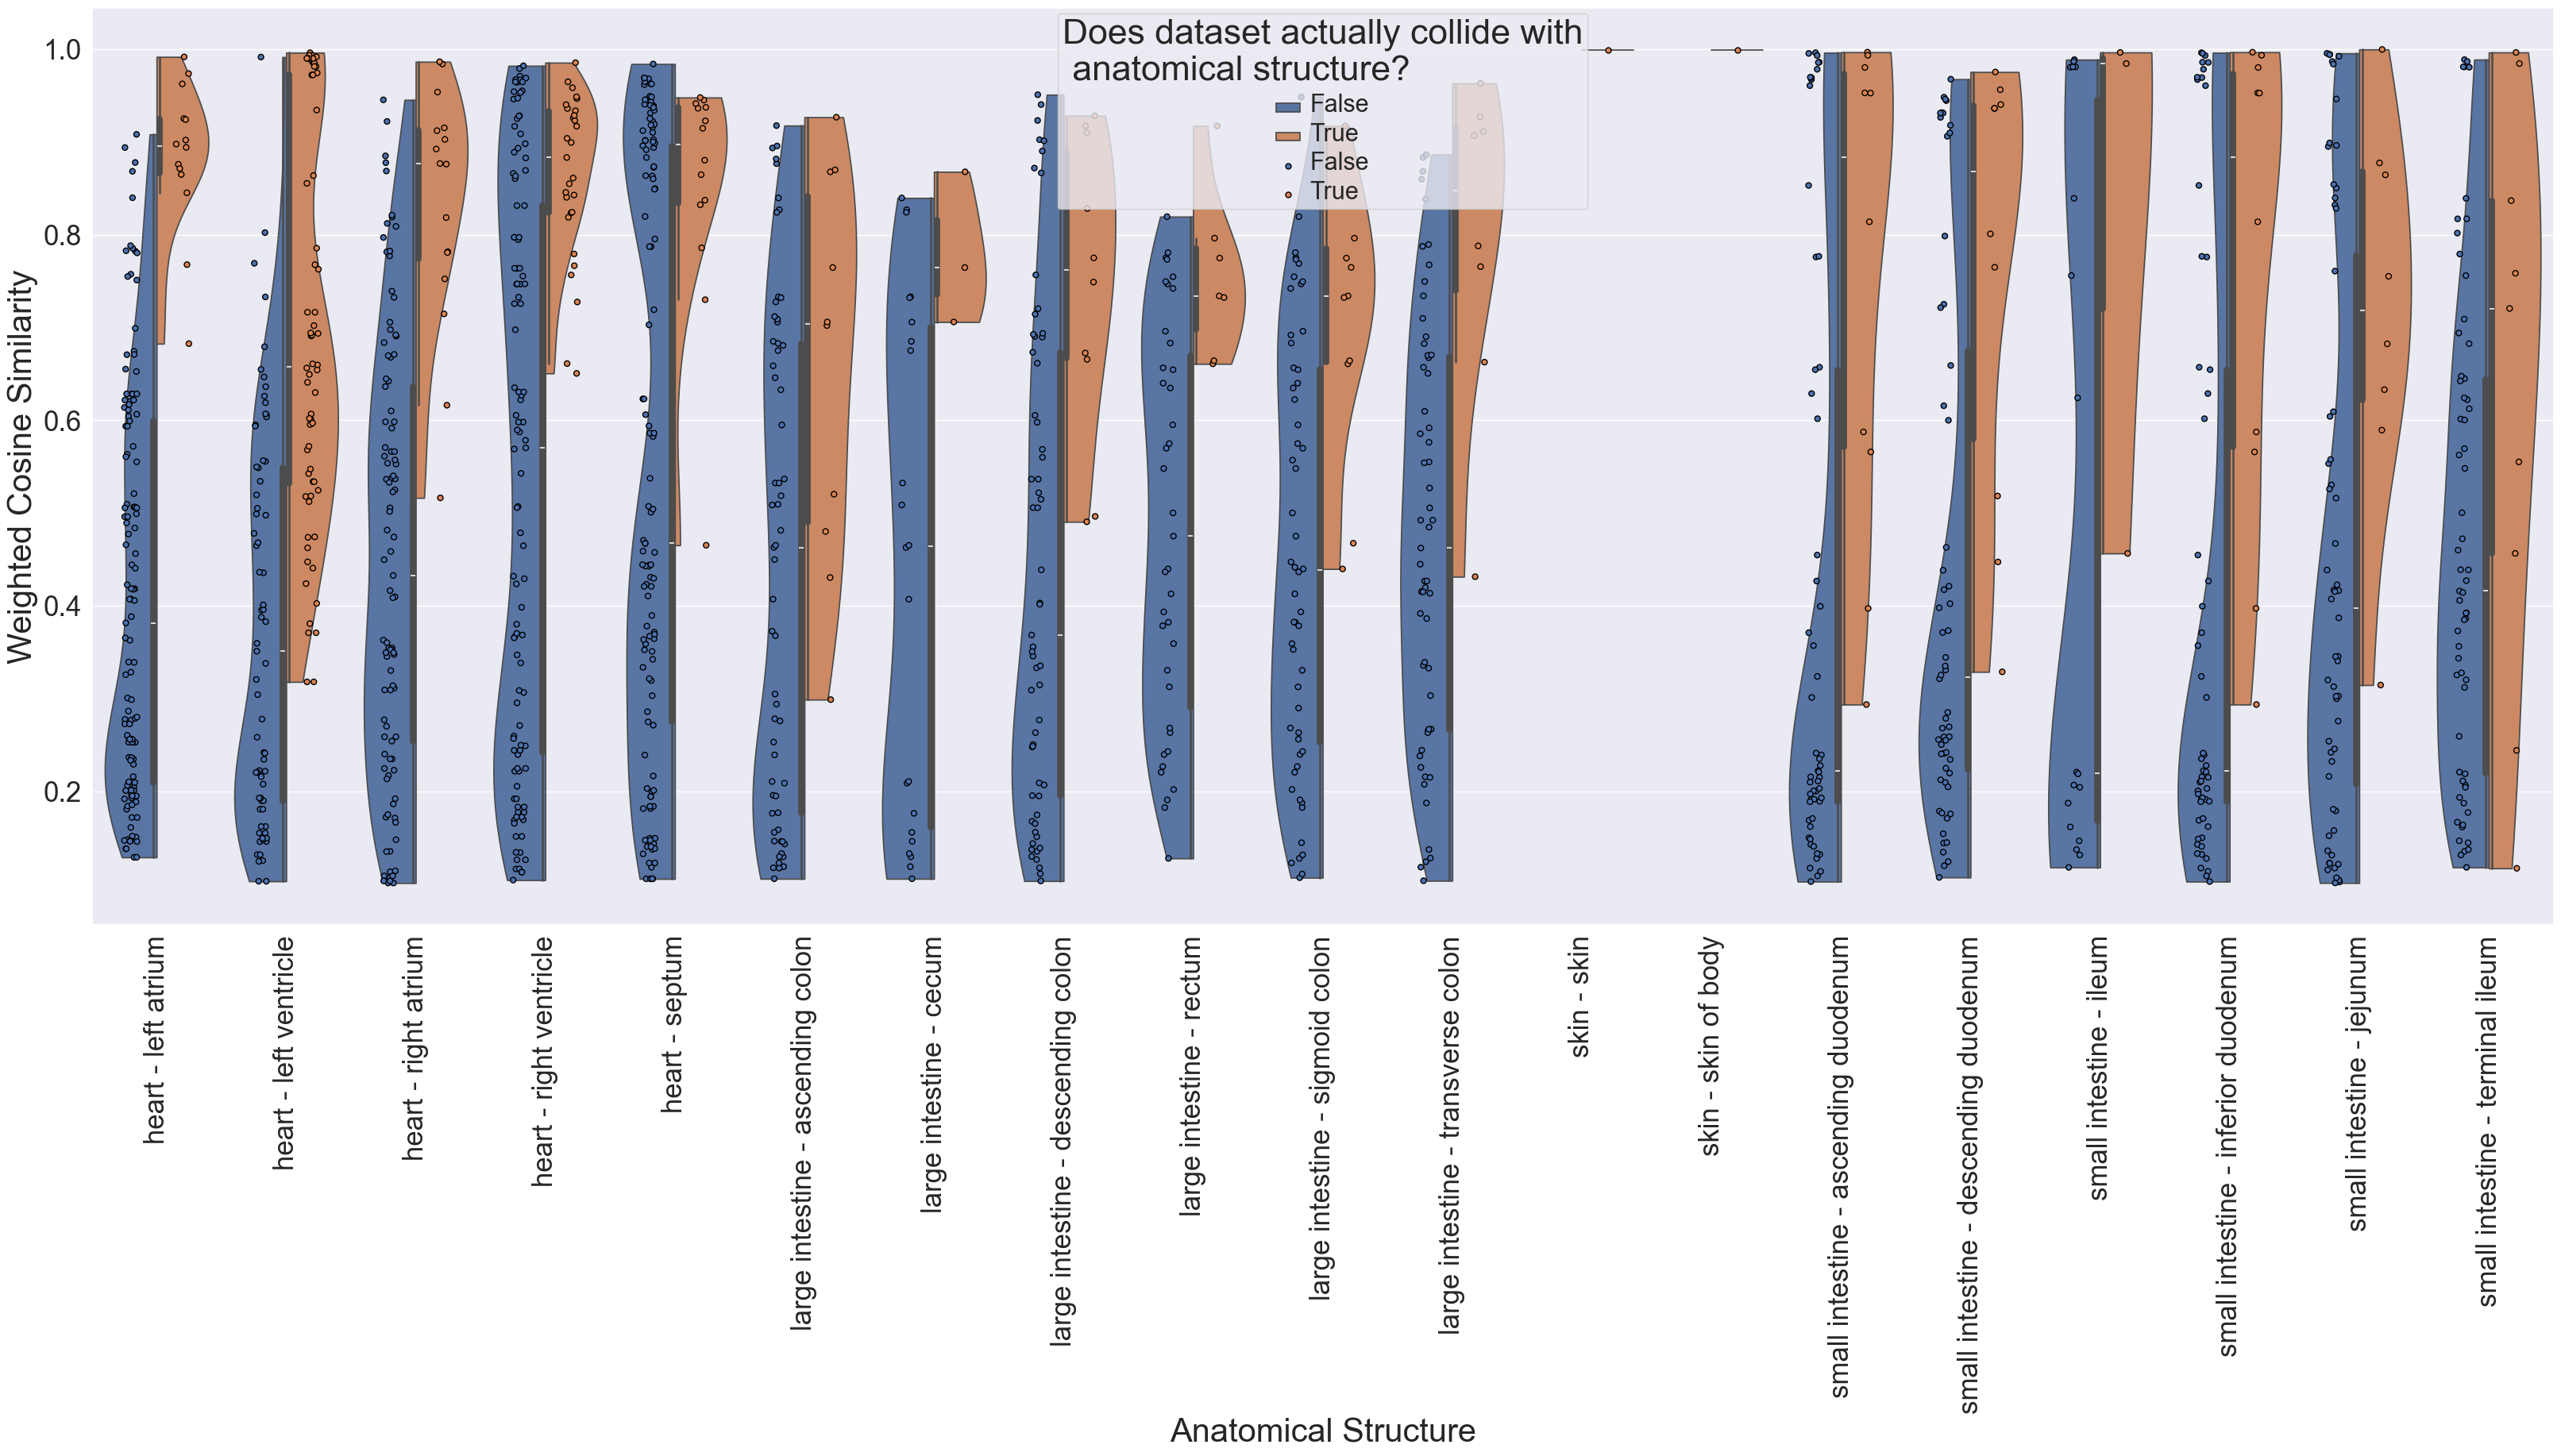

In [12]:
tool = "celltypist"
report_numbers("right atrium", tool, True)
report_numbers("right atrium", tool, False)
plot(tool)

### popV

For 16 out of 129 datasets annotated through popv for right atrium, does the extraction site of the dataset actually does collide with right atrium? True.
For 113 out of 129 datasets annotated through popv for right atrium, does the extraction site of the dataset actually does collide with right atrium? False.


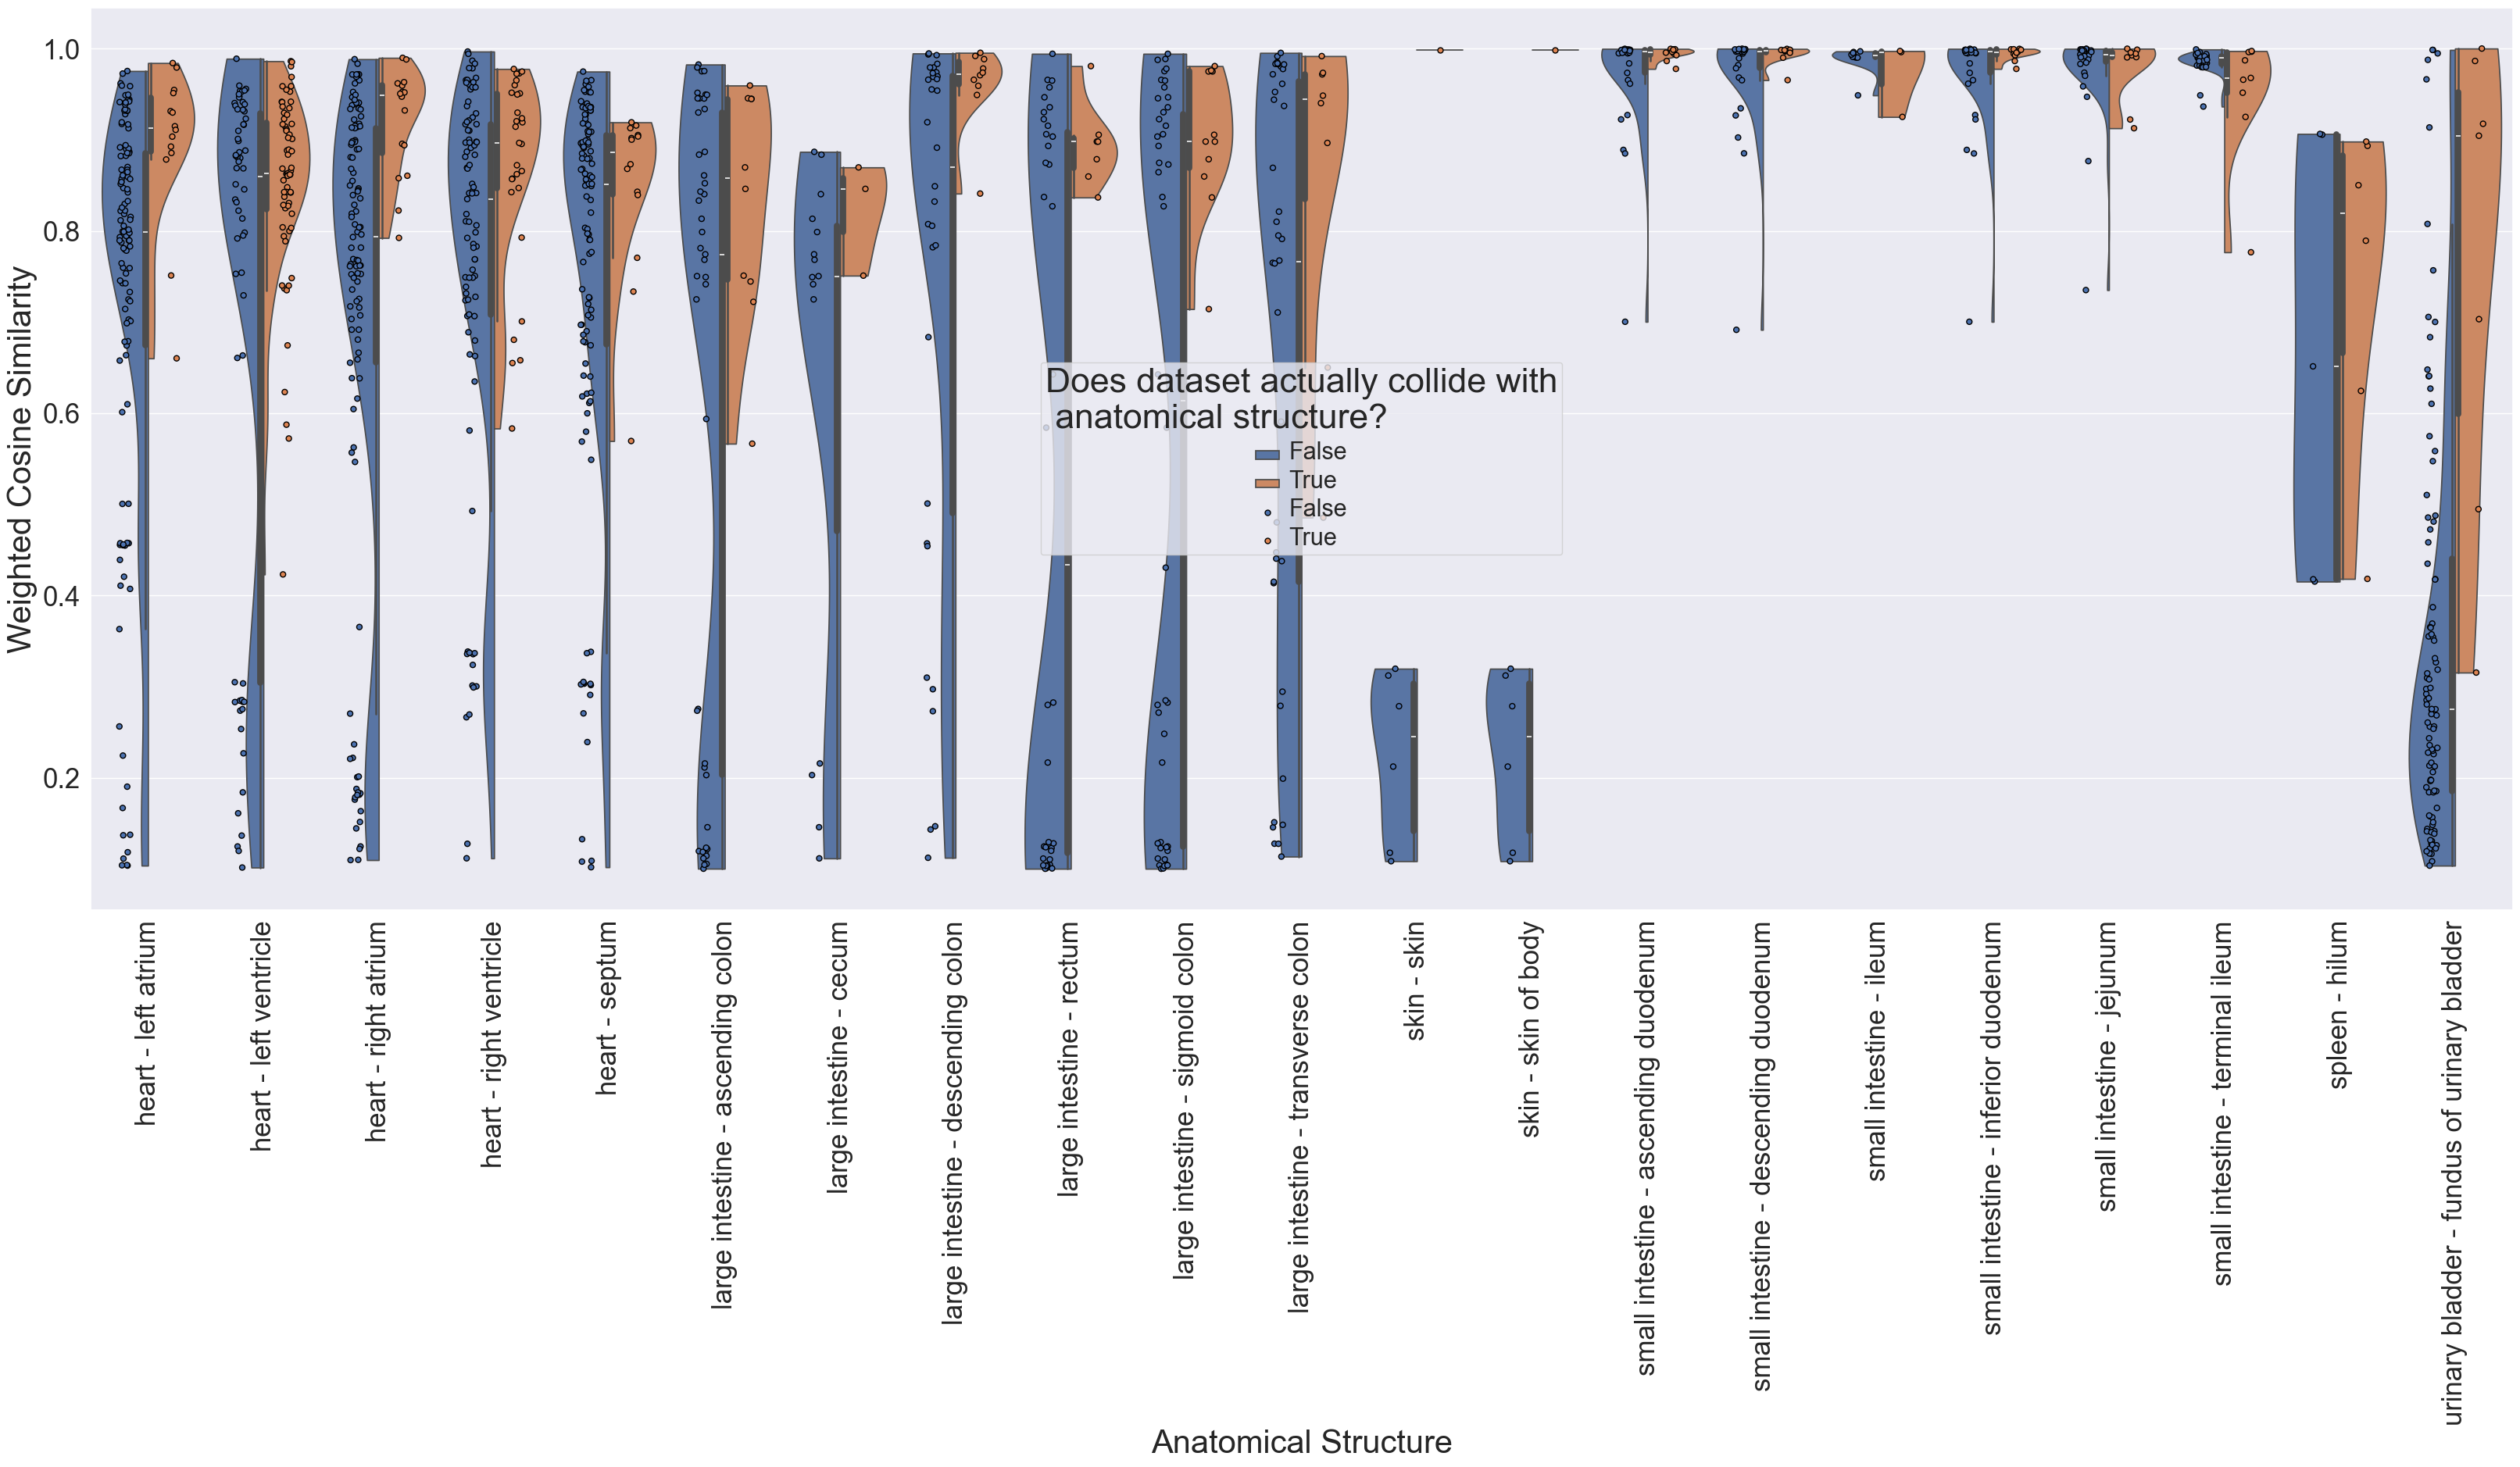

In [13]:
tool = "popv"
report_numbers("right atrium", tool, True)
report_numbers("right atrium", tool, False)
plot(tool)